# <center>Class 14: Model Building using LASSO </center>

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

## Data

In [3]:
path = os.path.join(os.pardir, 'data', 'airbnb_hackney_workfile.csv') # this will produce a path with the right syntax for your operating system
path

'../data/airbnb_hackney_workfile.csv'

In [4]:
# DATA IMPORT - FROM FILE
df = pd.read_csv(path)

In [5]:
df.head()

,usd_cleaning_fee,f_property_type,f_room_type,f_room_type2,f_cancellation_policy,f_bed_type,f_neighbourhood_cleansed,usd_price_day,p_host_response_rate,n_accommodates,...,f_bathroom,ln_number_of_reviews,f_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,f_minimum_nights
0,NaN,Apartment,Private room,Private,flexible,Real Bed,Hackney,65,100.0,2,...,1.0,1.386294,1.0,7.290975,53.158313,387.575921,2152089.0,3.157115e+09,4.521789,1.0
1,NaN,House,Private room,Private,moderate,Real Bed,Hackney,30,NaN,2,...,2.0,1.098612,1.0,6.350886,40.333749,256.155033,328329.0,1.881325e+08,4.499810,1.0
2,NaN,Apartment,Private room,Private,moderate,Couch,Hackney,150,100.0,7,...,1.0,3.496508,1.0,7.461066,55.667499,415.338854,3024121.0,5.258946e+09,4.574711,2.0
3,25.0,House,Private room,Private,moderate,Real Bed,Hackney,29,100.0,2,...,1.0,3.970292,2.0,6.385194,40.770708,260.328893,351649.0,2.085279e+08,4.543295,1.0
4,20.0,Apartment,Entire home/apt,Entire/Apt,moderate,Real Bed,Hackney,65,100.0,2,...,1.0,4.025352,2.0,7.288244,53.118506,387.140657,2140369.0,3.131360e+09,4.477337,2.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4496 entries, 0 to 4495
Data columns (total 90 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   usd_cleaning_fee           2769 non-null   float64
 1   f_property_type            4496 non-null   object 
 2   f_room_type                4496 non-null   object 
 3   f_room_type2               4496 non-null   object 
 4   f_cancellation_policy      4496 non-null   object 
 5   f_bed_type                 4496 non-null   object 
 6   f_neighbourhood_cleansed   4496 non-null   object 
 7   usd_price_day              4496 non-null   int64  
 8   p_host_response_rate       2970 non-null   float64
 9   n_accommodates             4496 non-null   int64  
 10  n_bathrooms                4487 non-null   float64
 11  n_review_scores_rating     3073 non-null   float64
 12  n_number_of_reviews        4496 non-null   int64  
 13  n_guests_included          4496 non-null   int64

### Feature Engineering

In [7]:
# where do we have missing variables now?
to_filter=df.isna().sum()
to_filter

usd_cleaning_fee           1727
f_property_type               0
f_room_type                   0
f_room_type2                  0
f_cancellation_policy         0
                           ... 
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
f_minimum_nights              1
Length: 90, dtype: int64

In [8]:
to_filter[to_filter>0].sort_values(ascending = False)

usd_cleaning_fee           1727
p_host_response_rate       1526
ln_review_scores_rating    1423
n_review_scores_rating     1423
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_reviews_per_month        1349
n_days_since               1349
d_reviews_per_month        1349
n_days_since3              1349
n_beds                       12
ln_beds                      12
f_bathroom                    9
n_bathrooms                   9
f_number_of_reviews           1
f_minimum_nights              1
dtype: int64

In [9]:
to_filter[to_filter>0].index

Index(['usd_cleaning_fee', 'p_host_response_rate', 'n_bathrooms',
       'n_review_scores_rating', 'n_reviews_per_month', 'n_beds',
       'n_days_since', 'd_reviews_per_month', 'ln_beds', 'f_bathroom',
       'f_number_of_reviews', 'ln_days_since', 'ln_days_since2',
       'ln_days_since3', 'n_days_since2', 'n_days_since3',
       'ln_review_scores_rating', 'f_minimum_nights'],
      dtype='object')

#### Missing values

In [10]:
# 1. drop if no target (already did)
df.dropna(subset=['price'], inplace = True)

In [11]:
# 2. imput when few, not that important
df['n_bathrooms']=df['n_bathrooms'].fillna(np.nanmedian(df['n_bathrooms'])) # !!! compute the median along the specified axis, while ignoring NaNs.
df['n_beds']=df['n_beds'].fillna(df['n_accommodates'])
df['f_bathroom']=df['f_bathroom'].fillna(1)
df['f_minimum_nights']=df['f_minimum_nights'].fillna(1)
df['f_number_of_reviews']=df['f_number_of_reviews'].fillna(1)
df['ln_beds']=df['ln_beds'].fillna(0)

In [12]:
df['n_bathrooms'].describe().map('{:.2f}'.format)

count    4496.00
mean        1.23
std         0.48
min         0.00
25%         1.00
50%         1.00
75%         1.50
max         8.00
Name: n_bathrooms, dtype: object

In [13]:
# 3. drop columns when many missing not important
df=df.drop(["usd_cleaning_fee", "p_host_response_rate"],axis=1)

In [14]:
# where do we have missing variables now?
to_filter=df.isna().sum()
to_filter[to_filter>0].index

Index(['n_review_scores_rating', 'n_reviews_per_month', 'n_days_since',
       'd_reviews_per_month', 'ln_days_since', 'ln_days_since2',
       'ln_days_since3', 'n_days_since2', 'n_days_since3',
       'ln_review_scores_rating'],
      dtype='object')

In [15]:
for var in ["flag_days_since","flag_review_scores_rating","flag_reviews_per_month"]:
    df[var]=[int(x) for x in df[var.replace('flag','n')].isna()]

In [16]:
df['flag_days_since'].count()

4496

In [17]:
# 4. Replace missing variables re reviews with zero, when no review + add flags
df['n_days_since']=df['n_days_since'].fillna(np.nanmedian(df['n_days_since']))
df['n_review_scores_rating']=df['n_review_scores_rating'].fillna(np.nanmedian(df['n_review_scores_rating']))
df['n_reviews_per_month']=df['n_reviews_per_month'].fillna(np.nanmedian(df['n_reviews_per_month']))

In [18]:
df.flag_days_since.value_counts()

flag_days_since
0    3147
1    1349
Name: count, dtype: int64

In [19]:
# Look at data
df.price.describe().map('{:,.2f}'.format)

count    4,496.00
mean        80.56
std         58.92
min         10.00
25%         40.00
50%         65.00
75%        100.00
max        850.00
Name: price, dtype: object

In [20]:
# where do we have missing variables now?
to_filter=df.isna().sum()
to_filter[to_filter>0]

d_reviews_per_month        1349
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
dtype: int64

In [21]:
###################################
# Business logic- define our prediction problem
###################################
# Decision
# Size, we need a normal apartment, 1-7persons
df=df.loc[df.n_accommodates < 8]

### EDA

**NOTE** Adding interation terms

In [22]:
#How is the average price changing in my district by `property_type`, `room_type` and the `bed_type`?
df.groupby(["f_property_type", "f_room_type"]).agg(
    mean_price=("price", np.mean), 
    count = ('price', 'size')
).style.format({'mean_price': '{:,.2f}', 'count': '{:,.0f}'})

In [23]:
df.groupby(["f_bed_type"]).agg(mean_price=("price", np.mean)).map('{:,.2f}'.format)

,mean_price
f_bed_type,
Couch,49.09
Real Bed,77.84


In [24]:
df.price.describe().map('{:,.2f}'.format)

count    4,393.00
mean        77.27
std         53.27
min         10.00
25%         40.00
50%         65.00
75%         99.00
max        850.00
Name: price, dtype: object

In [25]:
# How are extreme prices distributed?
df.price.quantile([0.75, 0.8, 0.9, 0.95, 0.99, 0.995]).map('{:,.2f}'.format)

0.750     99.00
0.800    103.00
0.900    140.00
0.950    180.00
0.990    254.12
0.995    300.00
Name: price, dtype: object

In [26]:
# We pick USD 400, above which all observations are excluded in the charts below.
dfu=df[df.price<400]

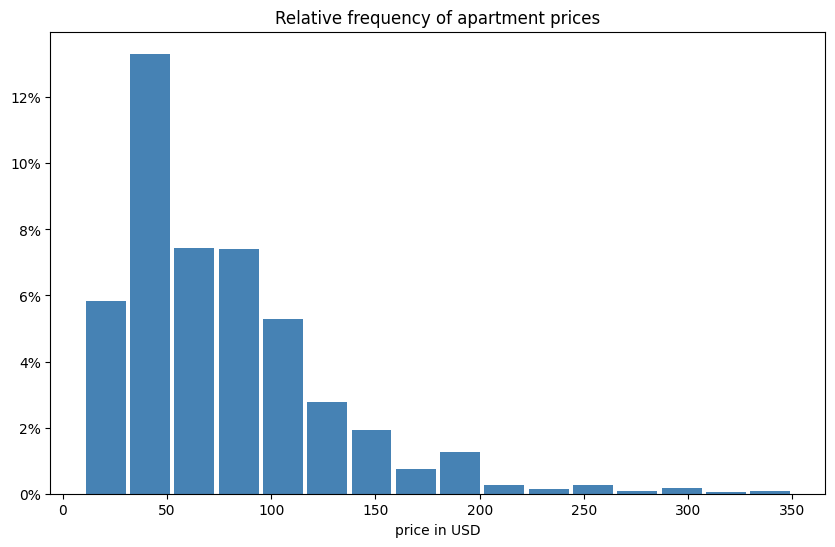

In [27]:
# relative frequencies with matplotlib

from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(dfu.price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
ax.set_xlabel('price in USD')
# ax.grid()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=0.1, decimals = 0))
ax.set_title('Relative frequency of apartment prices')
plt.show()

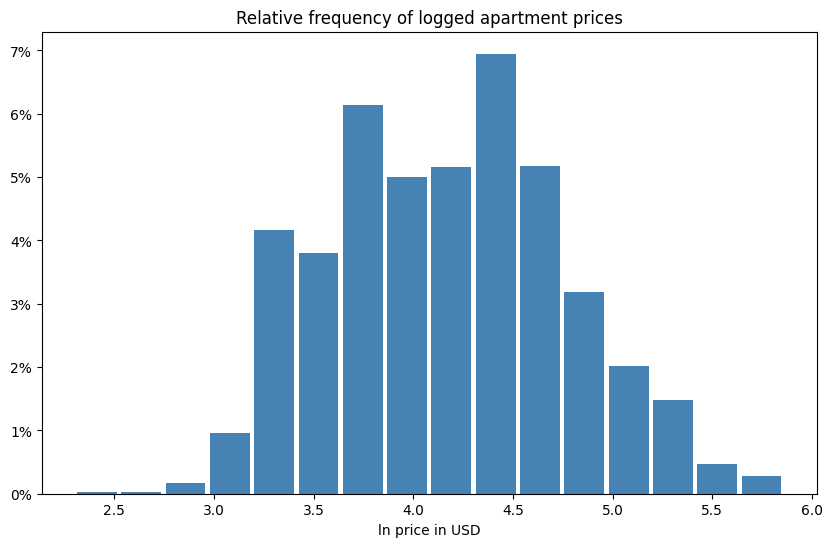

In [28]:
# relative frequencies with matplotlib

from matplotlib.ticker import PercentFormatter
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.hist(dfu.ln_price, bins = 16, density = True, rwidth = 0.9, color = 'steelblue')
# ax.set_xticks(range(0, df.price.max(), 2000))
ax.set_xlabel('ln price in USD')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=10, decimals = 0))
ax.set_title('Relative frequency of logged apartment prices')
plt.show()

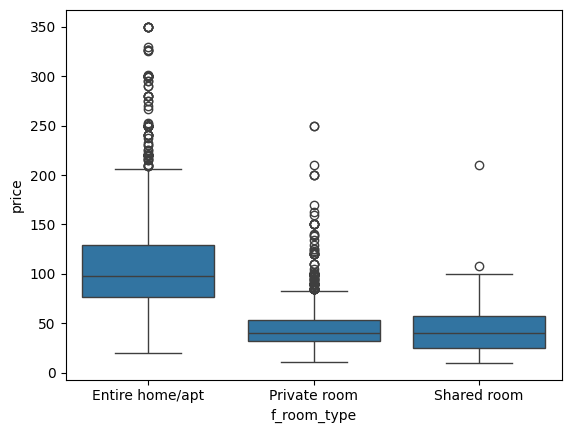

In [29]:
sns.boxplot(data = dfu, x = 'f_room_type', y = 'price', orient = 'v', order = ['Entire home/apt', 'Private room', 'Shared room'])
plt.show()

In [30]:
dfu.f_room_type.value_counts()

f_room_type
Private room       2252
Entire home/apt    2106
Shared room          27
Name: count, dtype: int64

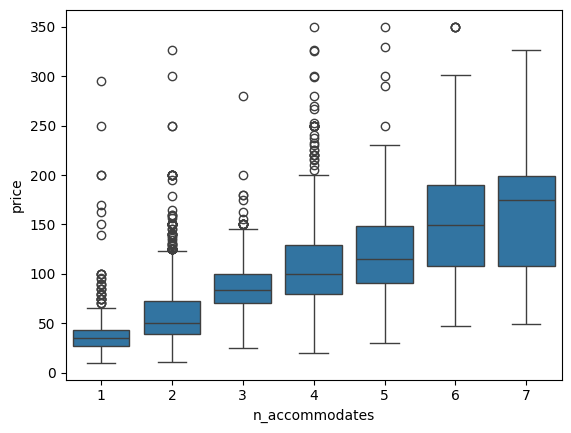

In [31]:
sns.boxplot(data = dfu, x = 'n_accommodates', y = 'price', orient = 'v')
plt.show()

In [32]:
dfu.n_accommodates.value_counts().sort_index()

n_accommodates
1     534
2    2328
3     259
4     765
5     162
6     287
7      50
Name: count, dtype: int64

### Modelling

**Basic variables**

In [33]:
basic_lev = (
    "n_accommodates",
    "n_beds",
    "f_property_type",
    "f_room_type",
    "n_days_since",
    "flag_days_since",
)
basic_add = ("f_bathroom", "f_cancellation_policy", "f_bed_type")
reviews = ("f_number_of_reviews", "n_review_scores_rating", "flag_review_scores_rating")
poly_lev = ("n_accommodates2", "n_days_since2", "n_days_since3")
# not use p_host_response_rate due to missing obs
amenities = list(df.filter(regex="^d_.*"))

In [34]:
amenities

['d_reviews_per_month',
 'd_24hourcheckin',
 'd_airconditioning',
 'd_breakfast',
 'd_buzzerwirelessintercom',
 'd_cabletv',
 'd_carbonmonoxidedetector',
 'd_cats',
 'd_dogs',
 'd_doorman',
 'd_doormanentry',
 'd_dryer',
 'd_elevatorinbuilding',
 'd_essentials',
 'd_familykidfriendly',
 'd_fireextinguisher',
 'd_firstaidkit',
 'd_freeparkingonpremises',
 'd_freeparkingonstreet',
 'd_gym',
 'd_hairdryer',
 'd_hangers',
 'd_heating',
 'd_hottub',
 'd_indoorfireplace',
 'd_internet',
 'd_iron',
 'd_keypad',
 'd_kitchen',
 'd_laptopfriendlyworkspace',
 'd_lockonbedroomdoor',
 'd_lockbox',
 'd_otherpets',
 'd_paidparkingoffpremises',
 'd_petsallowed',
 'd_petsliveonthisproperty',
 'd_pool',
 'd_privateentrance',
 'd_privatelivingroom',
 'd_safetycard',
 'd_selfcheckin',
 'd_shampoo',
 'd_smartlock',
 'd_smokedetector',
 'd_smokingallowed',
 'd_suitableforevents',
 'd_tv',
 'd_washer',
 'd_washerdryer',
 'd_wheelchairaccessible']

**Interactions**


**NOTE** For example, price per suare meter interacts with real estate type; i.e. flats' price is higher than houses', because they're in freuqnted places where avg. price is higher. 

In [35]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()
    
    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))
        
        # Adjust x positions for dodge effect
        if i == 1:
            x = x + 0.2
        else:
            x = x - 0.2
            
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')
    
    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )
    
    # Remove grid
    ax.grid(False)
    plt.show()
    
    return plt



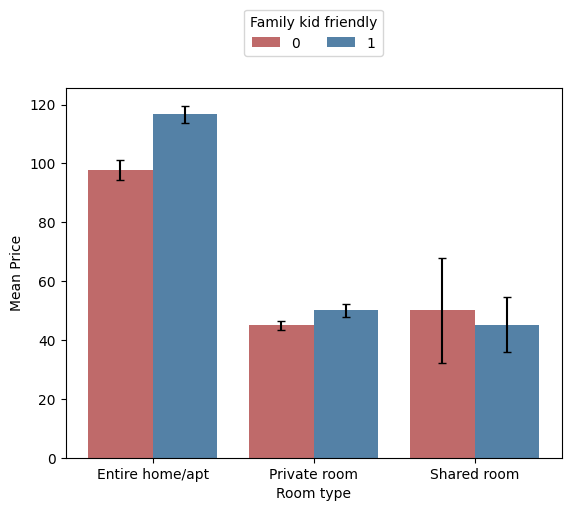

In [36]:
price_diff_by_variables(df,"f_room_type","d_familykidfriendly","Room type", "Family kid friendly");

Cancelation policy

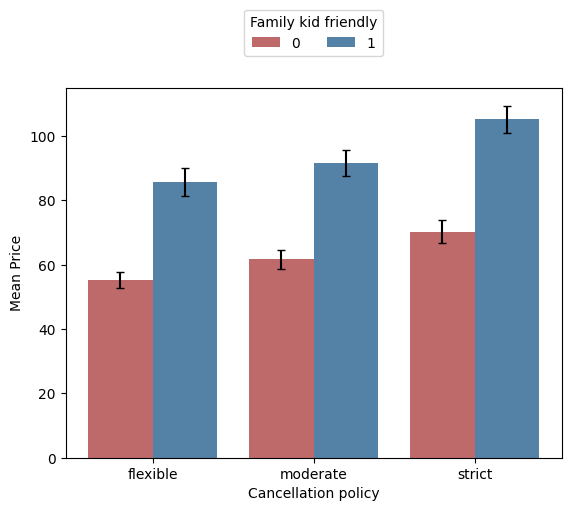

In [37]:
price_diff_by_variables(df, "f_cancellation_policy", "d_familykidfriendly", "Cancellation policy", "Family kid friendly");

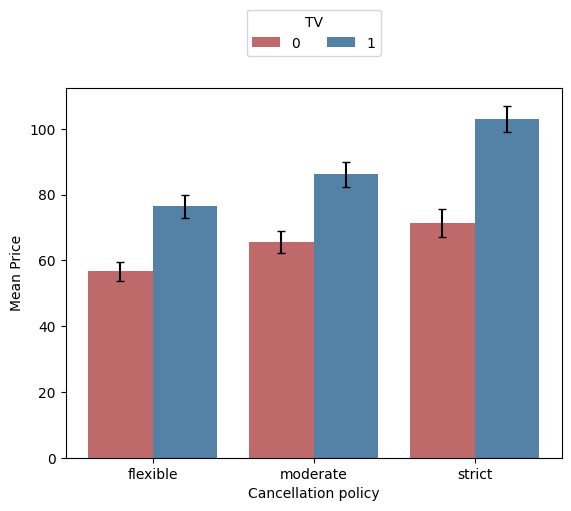

In [38]:
price_diff_by_variables(df, "f_cancellation_policy", "d_tv", "Cancellation policy", "TV");

Look up property type: cat and dog lovers

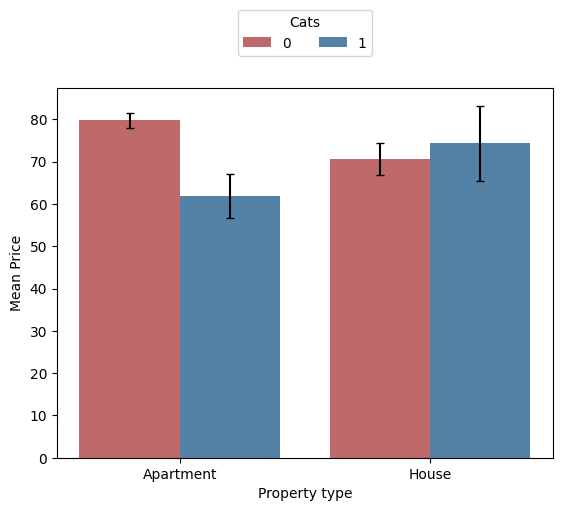

In [39]:
price_diff_by_variables(df, "f_property_type", "d_cats", "Property type", "Cats");

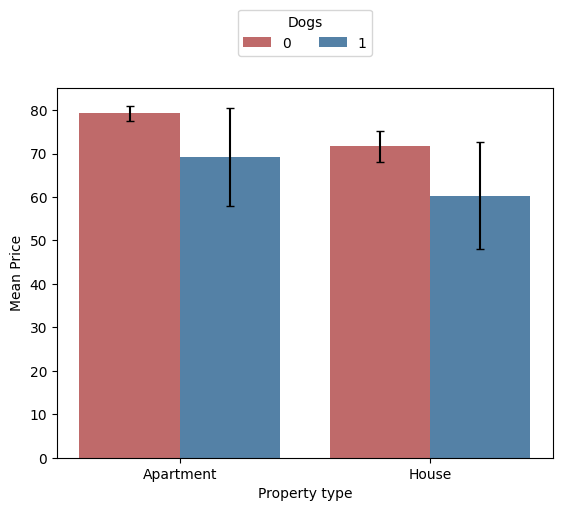

In [40]:
price_diff_by_variables(df, "f_property_type", "d_dogs", "Property type", "Dogs");

**Dummies, interactions suggested by graphs**

In [41]:
X1 = ("f_room_type*f_property_type",  "f_room_type*d_familykidfriendly")
X2= ("d_airconditioning*f_property_type", "d_cats*f_property_type", "d_dogs*f_property_type")
X3= "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * ("+ "+".join(amenities) +")"

In [42]:
modellev1="~ n_accommodates"
modellev2="~"+"+".join(basic_lev)
modellev3="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)
modellev4="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)
modellev5="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)
modellev6="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)
modellev7="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)
modellev8="~"+"+".join(basic_lev)+"+"+"+".join(basic_add)+"+"+"+".join(reviews)+"+"+"+".join(poly_lev)+"+"+"+".join(X1)+"+"+"+".join(X2)+"+"+"+".join(amenities)+"+"+X3

In [43]:
basic_add

('f_bathroom', 'f_cancellation_policy', 'f_bed_type')

In [44]:
modellev3

'~n_accommodates+n_beds+f_property_type+f_room_type+n_days_since+flag_days_since+f_bathroom+f_cancellation_policy+f_bed_type+f_number_of_reviews+n_review_scores_rating+flag_review_scores_rating'

#### Regressions with cross-validation

**Split train & holdout for cross-validation**

**NOTE** We should've done this at the beginning of notebook, as we already saw histograms etc. from holdout set!!! This is data snooping.

In [45]:
smp_size = round(0.2 * df.shape[0])-1

In [46]:
smp_size

878

In [47]:
# Set the seed to make results reproducable
np.random.seed(20250217)

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
df_work, df_holdout=train_test_split(df, test_size=smp_size)

In [50]:
df_work.shape

(3515, 91)

In [51]:
df_holdout.shape

(878, 91)

In [52]:
n_folds=5

In [53]:
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import mse,rmse
k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

In [54]:
def cv_reg(formula, df, kfold, testdf, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(df):
        df_train, df_test = df.iloc[train_index, :], df.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data = df_train).fit()
        else:
            model = smf.ols(formula, data = df_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(df_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [df_train["price"], model.predict(df_train)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [df_test["price"], model.predict(df_test)],
            axis=1,
            keys=["price", "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr["price"], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te["price"], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [56]:
cv_list = []
for i in [
    modellev1,
    modellev2,
    modellev3,
    modellev4,
    modellev5,
    modellev6,
    modellev7,
    modellev8,
]:
    cv_list += [cv_reg("price" + i, df, k, "HC0")]

In [57]:
summarize_cv(cv_list).map('{:,.3f}'.format)

,Model1,Model2,Model3,Model4,Model5,Model6,Model7,Model8
Fold1,42.225,39.335,38.280,34.845,34.771,34.623,33.607,31.695
Fold2,42.066,39.238,38.354,33.956,33.778,33.649,32.689,30.909
Fold3,38.939,36.071,35.282,33.507,33.398,33.252,32.338,30.673
Fold4,40.731,38.291,37.325,32.408,32.314,32.091,30.932,28.861
Fold5,42.229,39.493,38.582,35.572,35.459,35.331,34.218,32.213
Average,41.238,38.486,37.565,34.058,33.944,33.789,32.757,30.870


In [58]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Training")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 8):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("RMSE Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
df_rmse_levels = pd.DataFrame.from_dict(rmse_levels)
df_rmse_levels["nvars2"] = df_rmse_levels["nvars"] + 1

In [59]:
df_rmse_levels

,nvars,var,value,nvars2
0,1,RMSE Training,41.237844,2
1,7,RMSE Training,38.485689,8
2,14,RMSE Training,37.564621,15
3,16,RMSE Training,34.057558,17
4,21,RMSE Training,33.944016,22
5,27,RMSE Training,33.789171,28
6,71,RMSE Training,32.756739,72
7,293,RMSE Training,30.870065,294
8,1,RMSE Test,41.029270,2
9,7,RMSE Test,38.426556,8


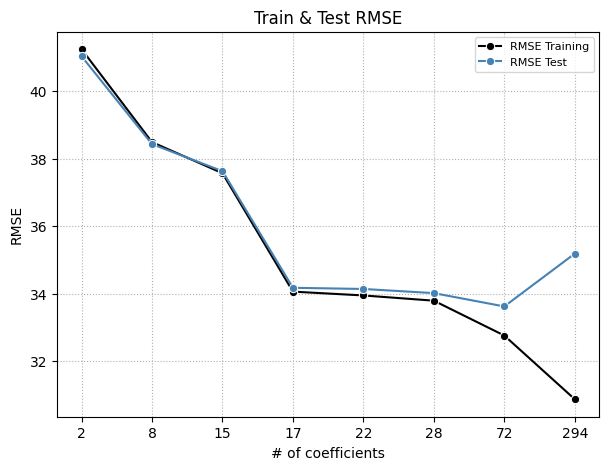

In [60]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    x = [str(x) for x in df_rmse_levels['nvars2']], 
    y = df_rmse_levels['value'], 
    hue = df_rmse_levels['var'], marker = 'o',
    palette = ['k', 'steelblue']
)
ax.set_title('Train & Test RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('# of coefficients')
ax.legend(fontsize = 8, title = None)
ax.grid(linestyle = ':')
plt.show();

#### LASSO

**Doing LASSO the hard way (aka *'naive' grid search*)**

In [ ]:
vars_model_7 = "(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * (d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet)"
vars_model_8 = modellev8

In [ ]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
y, X = patsy.dmatrices("price" + vars_model_8, df)

In [ ]:
y

In [ ]:
X.shape

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=smp_size, random_state=10
)

lambdas = [i/100 for i in range(5, 100,5)]

train_r_squared = np.zeros(len(lambdas))
test_r_squared = np.zeros(len(lambdas))

pred_num = X.shape[1]
coeff_a = np.zeros((len(lambdas), pred_num))

In [ ]:
lambdas

In [ ]:
train_r_squared

In [ ]:
X.shape[1]

In [ ]:
import datetime

In [ ]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):
    print(f"Run: {str(ind).rjust(2)}, lambda: {i:.2f}, start: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    reg = Lasso(alpha = i, random_state= 20250217) # In Python, Lasso's lambda is called alpha. Why?
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=cv, scoring="r2")

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

In [ ]:
results

In [ ]:
r_squared_df = (
    pd.DataFrame(
        {
            "$R^2$ Test set": test_r_squared,
            "$R^2$ Training set": train_r_squared,
            "lambda": lambdas,
        }
    )
    .melt(id_vars=["lambda"])
)

In [ ]:
r_squared_df.info()

In [ ]:
r_squared_df["variable"] = r_squared_df["variable"].astype("category").cat.reorder_categories(
    ["$R^2$ Training set", "$R^2$ Test set"]
)

In [ ]:
r_squared_df.info()

In [ ]:
r_squared_df

#### Plot results using `seaborn`

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.lineplot(
    data = r_squared_df, 
    x = 'lambda', y = 'value', hue = 'variable', 
    palette = ['k', 'steelblue'],
    marker = 'o'
)
ax.set_title('Train & Test $R^2$')
ax.set_ylabel('$R^2$')
ax.set_xlabel('lambda')
ax.set_xticks(lambdas[1::2])
ax.legend(fontsize = 10, title = None, labelcolor = ['k', 'steelblue'], loc='upper right', bbox_to_anchor=(0.4, 0.7))
plt.show();

In [ ]:
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

In [ ]:
reg_best = Lasso(alpha = df_lam.loc[df_lam['R_squared'].idxmax()]['lambda'])
reg_best.fit(X_train, y_train)

In [ ]:
reg_best.coef_[reg_best.coef_>0]

In [ ]:
print(reg_best.coef_)

In [ ]:
reg_best.get_params()

In [ ]:
from sklearn.metrics import mean_squared_error

print(f'{mean_squared_error(y_test, reg_best.predict(X_test)):,.2f}')

**LASSO using `GridSearch`**

- cross-validation strategies: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
- RepeatedKFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold
- scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- GridSearch: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
y,  X = patsy.dmatrices('price'+vars_model_8, df)

In [ ]:
vars_model_8

In [ ]:
X.shape

In [ ]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV` not only searches for the best parameters, but also automatically fits a new model on the whole training dataset with the parameters that yielded the best cross-validation performance.  

In [ ]:
%%time

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)

In [ ]:
print(f'RMSE: {(results.best_score_ * -1):,.3f}')

In [ ]:
results.cv_results_['rank_test_score']

In [ ]:
grid

In [ ]:
results.best_estimator_

### Diagnostics 

In [ ]:
model3_level = smf.ols('price'+modellev3, data=df_work).fit(cov_type='HC0')
model7_level = smf.ols('price'+modellev7, data=df_work).fit(cov_type='HC0')

In [ ]:
# look at holdout RMSE
model7_level_work_predictions = pd.concat(
    [df_work["price"], model7_level.predict(df_work)],
    axis=1,
    keys=["price", "predicted"],
)

In [ ]:
model7_level_work_predictions.tail()

In [ ]:
df_work.iloc[-3:].T

In [ ]:
model7_level_work_predictions = model7_level_work_predictions[~model7_level_work_predictions.isna().any(axis=1)]
model7_level_work_rmse = rmse(model7_level_work_predictions["price"], model7_level_work_predictions["predicted"], axis=0)

In [ ]:
model7_level_work_rmse

In [ ]:
model7_level_holdout_predictions = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)
model7_level_holdout_predictions = model7_level_holdout_predictions[~model7_level_holdout_predictions.isna().any(axis=1)]
model7_level_holdout_rmse = rmse(model7_level_holdout_predictions["price"], model7_level_holdout_predictions["predicted"], axis=0)
print(
    f"RMSE work:{round(model7_level_work_rmse,2)}",
    "\t",
    f"RMSE holdout:{model7_level_holdout_rmse:.2f}",
)

#### Charting fitted vs actual

In [ ]:
Ylev=df_holdout['price']
"""meanY=Ylev.mean()
sdY=Ylev.std()
meanY_m2SE = meanY -1.96 * sdY
meanY_p2SE = meanY + 1.96 * sdY
Y5p=Ylev.quantile(.05)
Y95p=Ylev.quantile(.95)"""

Note: the `statsmodels` API is kind of reticent in its documentation. So much about the [summary_frame()](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.PredictionResults.summary_frame.html#statsmodels.regression.linear_model.PredictionResults.summary_frame) method...

In [ ]:
model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

In [ ]:
# Create df frame with the real and predicted values
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.05)

df_ = pd.concat(
    [df_holdout["price"], model7_level.predict(df_holdout)],
    axis=1,
    keys=["price", "predicted"],
)

In [ ]:
df_.isna().sum()

In [ ]:
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["Ylev"] = df_["price"]

`pd.DataFrame.any()`: Return whether any element is True, potentially over an axis. 
Returns False unless there is at least one element within a series or along a Dataframe axis that is True or equivalent (e.g. non-zero or non-empty).

In [ ]:
x = np.linspace(0, 300, df_diagnostic.shape[0])

plt.figure(figsize = (6,6))
ax = sns.scatterplot(
    data=df_diagnostic, x="mean", y="Ylev",
    s = 25, color = 'steelblue'
)
plt.plot(x,x, color = 'k')
ax.set_xlim(0,300)
ax.set_ylim(0,300)
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.set_title('Actual vs predicted in USD')
plt.show()

#### Redo predicted values at 80% PI

In [ ]:
dt = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_extra = pd.concat(
    [
        df_holdout["price"],
        df_holdout["n_accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "n_accommodates", "predicted"],
)
df_extra = df_extra[~df_extra.isna().any(axis=1)].reset_index(drop=True)
dt["n_accommodates"] = df_extra["n_accommodates"]
dt["Ylev"] = df_extra["price"]
dt["elev"] = dt["Ylev"] - dt["mean"]

In [ ]:
df_diagnostic = model7_level.get_prediction(df_holdout).summary_frame(alpha=0.2)
df_ = pd.concat(
    [
        df_holdout["price"],
        df_holdout["n_accommodates"],
        model7_level.predict(df_holdout),
    ],
    axis=1,
    keys=["price", "n_accommodates", "predicted"],
)
df_ = df_[~df_.isna().any(axis=1)].reset_index(drop=True)
df_diagnostic["n_accommodates"] = df_["n_accommodates"]
df_diagnostic["Ylev"] = df_["price"]
df_diagnostic["elev"] = df_diagnostic["Ylev"] - df_diagnostic["mean"]

In [ ]:
predictionlev_holdout_summary = df_diagnostic.groupby(by=["n_accommodates"]).mean().reset_index()

In [ ]:
predictionlev_holdout_summary

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for mean values
ax.bar(predictionlev_holdout_summary['n_accommodates'],
       predictionlev_holdout_summary['mean'],
       color='steelblue',
       alpha=0.7)

# Plot error bars for observations
ax.errorbar(predictionlev_holdout_summary['n_accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['obs_ci_lower'],
                  predictionlev_holdout_summary['obs_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='none',
            color='grey',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Plot error bars for means
ax.errorbar(predictionlev_holdout_summary['n_accommodates'],
            predictionlev_holdout_summary['mean'],
            yerr=[predictionlev_holdout_summary['mean'] - predictionlev_holdout_summary['mean_ci_lower'],
                  predictionlev_holdout_summary['mean_ci_upper'] - predictionlev_holdout_summary['mean']],
            fmt='bo',
            color='k',
            capsize=5,
            capthick=3,
            elinewidth=3)

# Customize axes and labels
ax.set_xlabel('Accommodates (Persons)')
ax.set_ylabel('Predicted price (US dollars)')
ax.set_title('Mean predictions and confidence intervals')

# Set style similar to theme_bw()
ax.grid(True, linestyle='-', alpha=0.2)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_color('black')

# Adjust layout
plt.tight_layout()

# Return the plot
